# **Project 2: Thực hành xây dựng và đánh giá mô hình Unet trên bộ dữ liệu ISBI-một bộ dữ liệu về phân khúc cấu trúc thần kinh nơ ron.**

>Các mô hình Unet được áp dụng bao gồm:

- Kiến trúc 1: Kế thừa lại kiến trúc chuẩn từ bài báo gốc của mạng Unet. Các bức ảnh được resize về đầu vào có kích thước (572, 572) và Output sẽ có kích thước là (386, 386)

- Kiến trúc 2: Chuẩn hóa lại kích thước output sao cho bằng với kích thước của input shape và cùng bằng (512, 512)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/20202/Computer Vision/Project2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/20202/Computer Vision/Project2


In [ ]:
import glob2
import glob
# "The glob module finds all the pathnames matching a specified pattern(...)"
import numpy as np
import matplotlib.pyplot as plt
import cv2

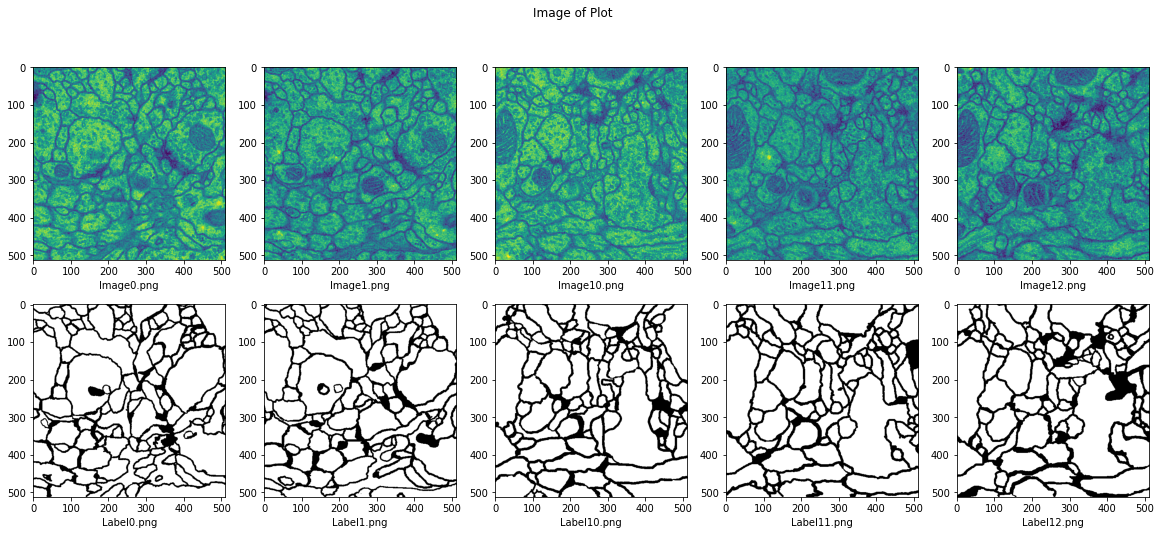

In [ ]:
# show 5 image
img5 = sorted(glob2.glob('./data/train/image/*.png'))[:5]
label5 = sorted(glob2.glob('./data/train/label/*.png'))[:5]

fig, ax = plt.subplots(2, 5, figsize=(20, 8)) # figsize của cả khung to chứa tất cả ảnh to
fig.suptitle('Image of Plot')

for i, path in enumerate(img5):
  img = plt.imread(path)
  ax[0, i].imshow(img)
  ax[0, i].set_xlabel('Image' + path.split('/')[-1])

for i, path in enumerate(label5):
  img = plt.imread(path)
  ax[1, i].imshow(img, cmap='gray')
  ax[1, i].set_xlabel('Label' + path.split('/')[-1])

>Nhãn 0 là các vị trí thuộc dây thần kinh, nhãn 1 là vị trí thuộc vùng nền

# **Sử dụng Keras**

# **Unet Version 1**

Đây là kiến trúc chuẩn của mạng Unet: bài báo sử dụng ảnh đầu vào có kích thước (572x572x1) và đầu ra có 2 lớp
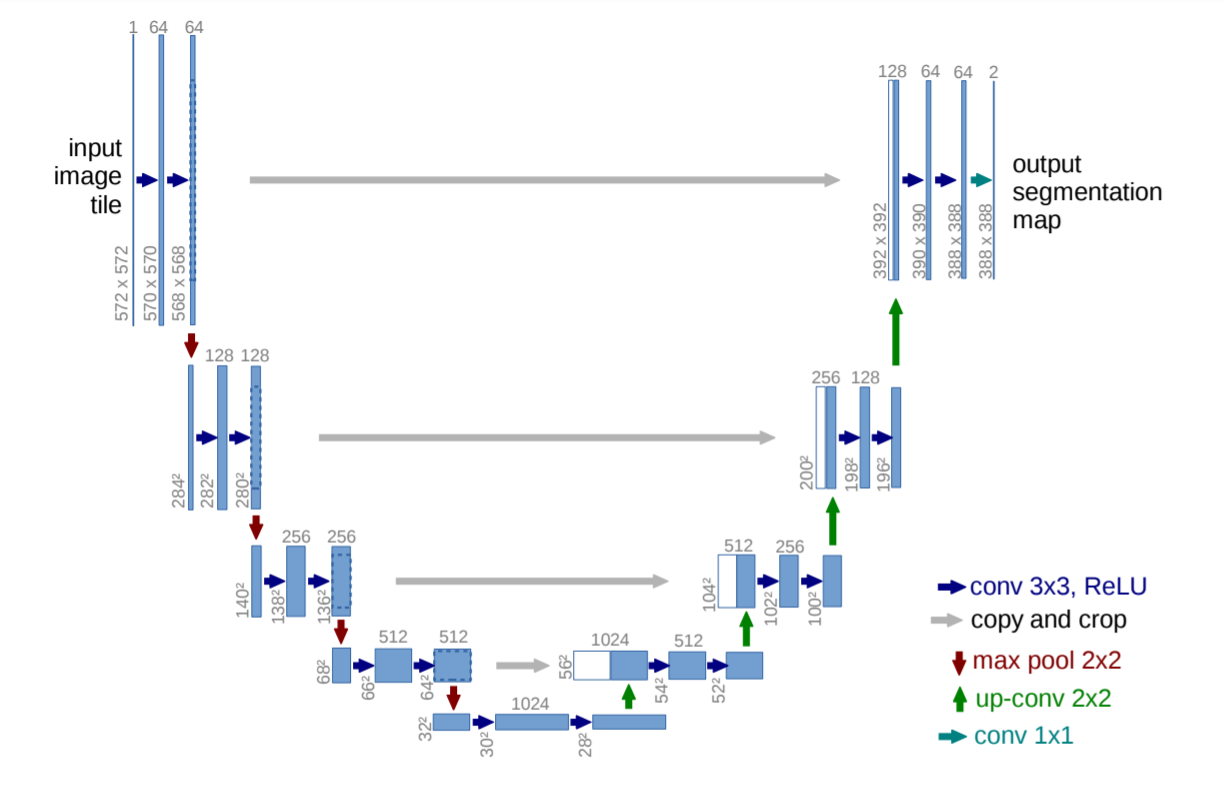

In [ ]:
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
INPUT_SHAPE = 572 # (572x572x3)
OUTPUT_SHAPE = 388 # (388x388x1)

def downsample_cnn_block(block_input, channel, is_first=False):
  if is_first: # nếu là khối đầu tiên
    conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(block_input)
    conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = MaxPool2D(pool_size=2)(block_input)
    conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(maxpool)
    conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(conv1)
    return [maxpool, conv1, conv2]

def upsample_cnn_block(block_input, block_counterpart, channel, is_last=False):
  # block counterpart là khối đối xứng bên kia để concat
  upconv = Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)

  # Crop block counterpart
  shape_input = upconv.shape[2] # kích thước đầu ra của layer (none, height, width, channel)
  shape_counterpart = block_counterpart.shape[2]

  # do kích thước nhánh bên phải có thể lớn hơn nên cần tính kích thước phần bỏ đi
  crop_size = int((shape_counterpart-shape_input)/2)
  # ((top_crop, bottom_crop), (left_crop, right_crop))
  block_counterpart_crop = Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = Concatenate(axis=-1)([block_counterpart_crop, upconv])
  conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(concat)
  conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, activation='relu')(conv1)
  if is_last:
    conv3 = Conv2D(filters=1, kernel_size=1, strides=1, activation='softmax')(conv2)
    return [concat, conv1, conv2, conv3]
  return [upconv, concat, conv1, conv2]

def create_model():
  ds_block1 = downsample_cnn_block(Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = downsample_cnn_block(ds_block4[-1], channel=1024)
  
  us_block4 = upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = create_model()
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 572, 572, 3) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 570, 570, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 568, 568, 64) 36928       conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 284, 284, 64) 0           conv2d_58[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Phân chia path train/validation
# data gồm tập ảnh đã được augumentation và tập ảnh gốc ban đầu, trong đó aug là thư mục chứa ảnh augument và nhãn của nó, tên của ảnh nhãn có thêm 'mask_'

# đoạn code sau nhằm tương ứng vị trí của ảnh và nhãn
# lấy tên của tất cả ảnh trong thư mục aug
img_aug = glob2.glob('./data/train/aug/*.png')
# lấy đường dẫn của các nhãn
label_path_aug = [item for item in img_aug if 'mask_' in item]
# lấy tên của các ảnh 
img_names = [item.split('/')[-1] for item in label_path_aug]
# lấy đường dẫn ảnh tương ứng với các nhãn
img_path_aug = ['./data/train/aug/image'+item[4:] for item in img_names]

# đường dẫn của ảnh và nhãn của ảnh gốc ban đầu
img_paths = glob2.glob('./data/train/image/*.png')
label_paths = ['./data/train/label/'+ path.split('/')[-1] for path in img_paths]

# gộp đường dẫn ảnh gốc và augumentation
img_paths += img_path_aug
label_paths += label_path_aug

# chia ngẫu nhiên tập train, validation tới tỷ lệ 80:20
train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(img_paths, label_paths, test_size=0.2)


In [ ]:
print(img_paths)
print(label_paths)

['./data/train/image/22.png', './data/train/image/15.png', './data/train/image/5.png', './data/train/image/11.png', './data/train/image/16.png', './data/train/image/28.png', './data/train/image/21.png', './data/train/image/19.png', './data/train/image/12.png', './data/train/image/29.png', './data/train/image/2.png', './data/train/image/3.png', './data/train/image/4.png', './data/train/image/9.png', './data/train/image/7.png', './data/train/image/27.png', './data/train/image/1.png', './data/train/image/6.png', './data/train/image/17.png', './data/train/image/26.png', './data/train/image/13.png', './data/train/image/14.png', './data/train/image/8.png', './data/train/image/23.png', './data/train/image/25.png', './data/train/image/0.png', './data/train/image/10.png', './data/train/image/24.png', './data/train/image/18.png', './data/train/image/20.png', './data/train/aug/image_6_5544540.png', './data/train/aug/image_22_2808126.png', './data/train/aug/image_8_4974953.png', './data/train/aug/

In [ ]:
# Tập train được lấy ngẫu nhiên 72 ảnh, tập valid lấy 18 ảnh còn lại
# Tỷ lệ train/validation là 80:20

# đọc ảnh bằng cv2 cho ra mảng
def image_read_paths(img_paths, label_paths):
  X, Y = [], []
  for img_path, label_path in zip(img_paths, label_paths):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

    label = cv2.imread(label_path)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label = cv2.resize(label, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label = np.array(label == 255).astype('float32')
    label = label[..., np.newaxis]
    
    X.append(img)
    Y.append(label)
  return np.array(X), np.array(Y)

X_train, Y_train = image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)



(72, 572, 572, 3) (72, 388, 388, 1)
(18, 572, 572, 3) (18, 388, 388, 1)


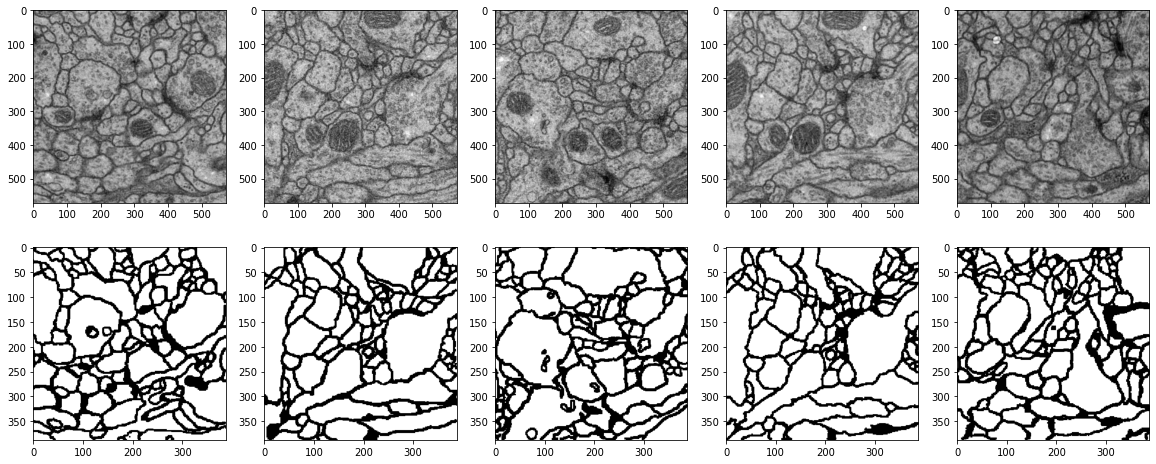

In [ ]:
# Hiển thị một số ảnh và nhãn tương ứng trong tập train
fig, ax = plt.subplots(2, 5, figsize=(20, 8)) # figsize của cả khung to chứa tất cả ảnh to

for i, img in enumerate(X_train[:5]):
  ax[0, i].imshow(img)

for i, img in enumerate(Y_train[:5]):
  ax[1, i].imshow(img[:,:,0], cmap='gray')

In [ ]:
#  nếu val_loss không giảm sau 4 epochs thì dừng (patience=4)
H =model.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 100,
  callbacks = (EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True))
  )

model.save('./model_version1_softmax_keras.h5')

Epoch 1/100
9/9 [==============================] - 14s 1s/step - loss: 3.2456 - accuracy: 0.7113 - val_loss: 1.1374 - val_accuracy: 0.7231
Epoch 2/100
9/9 [==============================] - 13s 1s/step - loss: 0.9076 - accuracy: 0.7115 - val_loss: 0.6275 - val_accuracy: 0.7231
Epoch 3/100
9/9 [==============================] - 13s 1s/step - loss: 0.6541 - accuracy: 0.7178 - val_loss: 0.6362 - val_accuracy: 0.7231
Epoch 4/100
9/9 [==============================] - 13s 1s/step - loss: 0.6356 - accuracy: 0.7149 - val_loss: 0.6142 - val_accuracy: 0.7231
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 0.6227 - accuracy: 0.7140 - val_loss: 0.6051 - val_accuracy: 0.7231
Epoch 6/100
9/9 [==============================] - 13s 1s/step - loss: 0.6156 - accuracy: 0.7109 - val_loss: 0.6040 - val_accuracy: 0.7231
Epoch 7/100
9/9 [==============================] - 13s 1s/step - loss: 0.6129 - accuracy: 0.7110 - val_loss: 0.6016 - val_accuracy: 0.7231
Epoch 8/100
9/9 [==========

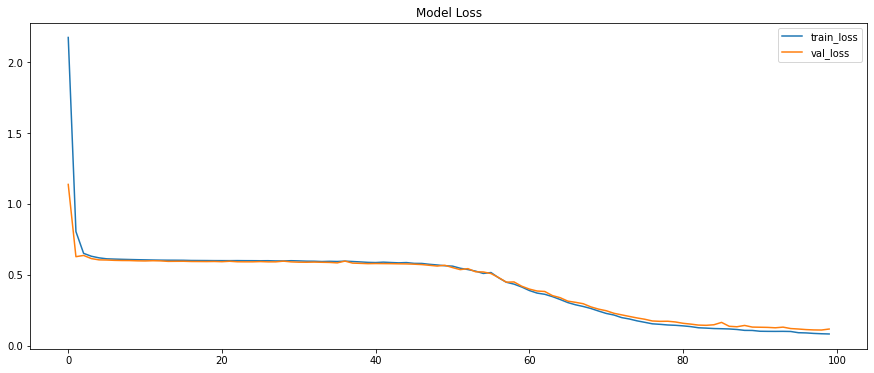

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

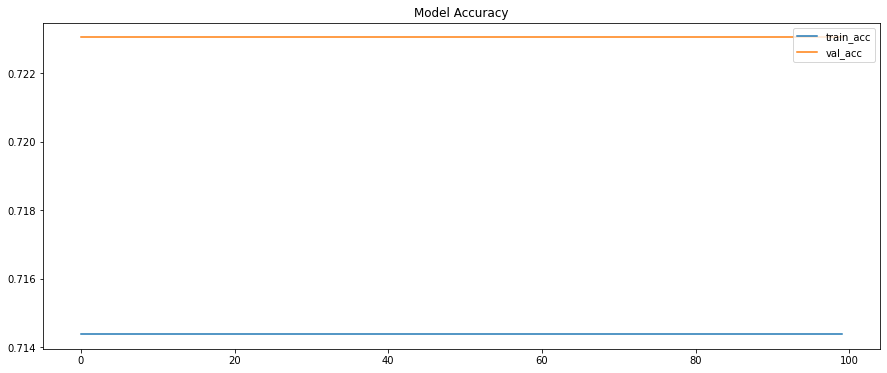

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'predicted')

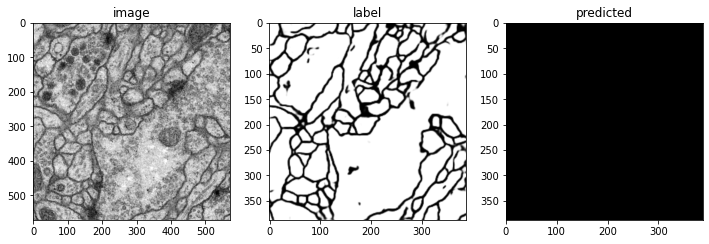

In [ ]:
# Predict
img_path = './data/test/0.png'
label_path = './data/test/0_predict.png'

img = cv2.imread(img_path)
img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

label = cv2.imread(label_path)
label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
label = cv2.resize(label, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
model = load_model('./model_version1_softmax_keras.h5')
predict = model.predict(img[np.newaxis,...])

predict[predict<0.5] = 0
predict[predict>=0.5] = 1

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img)
ax[0].set_title('image')
ax[1].imshow(label, cmap='gray')
ax[1].set_title('label')
ax[2].imshow(predict[0][:,:,0], cmap='gray')
ax[2].set_title('predicted')


In [ ]:
predict[0][:,:,0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

# **Unet Version 2**

>Thay đổi kích thước Input và Output là bằng nhau -> mô hình sẽ không bị mất mát nhiều thông tin về vị trí và không gian. Để làm được điều này, đặt padding='same'. Còn lại mọi thứ xây dựng giống hệt version 1

In [ ]:
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
INPUT_SHAPE = 512
OUTPUT_SHAPE = 512

def downsample_cnn_block(block_input, channel, is_first=False):
  if is_first: # nếu là khối đầu tiên
    conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(block_input)
    conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = MaxPool2D(pool_size=2)(block_input)
    conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(maxpool)
    conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(conv1)
    return [maxpool, conv1, conv2]

def upsample_cnn_block(block_input, block_counterpart, channel, is_last=False):
  # block counterpart là khối đối xứng bên kia để concat
  upconv = Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)

  concat = Concatenate(axis=-1)([block_counterpart, upconv])
  conv1 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(concat)
  conv2 = Conv2D(filters=channel, kernel_size=3, strides=1, padding='same', activation='relu')(conv1)
  if is_last:
    conv3 = Conv2D(filters=1, kernel_size=1, strides=1, activation='softmax', padding='same')(conv2)
    return [concat, conv1, conv2, conv3]
  return [upconv, concat, conv1, conv2]

def create_model():
  ds_block1 = downsample_cnn_block(Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = downsample_cnn_block(ds_block4[-1], channel=1024)

  us_block4 = upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Phân chia path train/validation
# data gồm tập train(aug và image), trong đó aug là thư mục chứa ảnh augument và
# nhãn của nó, tên của ảnh nhãn có thêm 'mask_'

# đoạn code sau nhằm tương ứng vị trí của ảnh và nhãn
# lấy tên của tất cả ảnh trong thư mục aug
img_aug = glob2.glob('./data/train/aug/*.png')
# lấy đường dẫn của các nhãn
label_path_aug = [item for item in img_aug if 'mask_' in item]
# lấy tên của các ảnh 
img_names = [item.split('/')[-1] for item in label_path_aug]
# lấy đường dẫn ảnh
img_path_aug = ['./data/train/aug/image'+item[4:] for item in img_names]

# đường dẫn của ảnh là label trong thư mục train
img_paths = glob2.glob('./data/train/image/*.png')
label_paths = ['./data/train/label/'+ path.split('/')[-1] for path in img_paths]

# gộp đường dẫn
img_paths += img_path_aug
label_paths += label_path_aug

train_img_paths, val_img_paths, train_label_paths, val_label_paths = train_test_split(img_paths, label_paths, test_size=0.2)


In [ ]:
# Tập traing được lấy ngẫu nhiên 72 ảnh, tập valid lấy 18 ảnh còn lại
# Tỷ lệ train/validation là 80:20

# đọc ảnh bằng cv2 cho ra mảng
def image_read_paths(img_paths, label_paths):
  X, Y = [], []
  for img_path, label_path in zip(img_paths, label_paths):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    label = cv2.imread(label_path)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label = cv2.resize(label, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label = np.array(label == 255).astype('float32')
    label = label[..., np.newaxis]
    X.append(img)
    Y.append(label)
  return np.array(X), np.array(Y)

X_train, Y_train = image_read_paths(train_img_paths, train_label_paths)
print(X_train.shape, Y_train.shape)
X_val, Y_val = image_read_paths(val_img_paths, val_label_paths)
print(X_val.shape, Y_val.shape)


(72, 512, 512, 3) (72, 512, 512, 1)
(18, 512, 512, 3) (18, 512, 512, 1)


In [ ]:
#  nếu loss không giảm sau 4 epochs thì dừng (patience=4)
H =model.fit(X_train, Y_train,
  validation_data = (X_val, Y_val),
  batch_size = 8,
  epochs = 100,
  callbacks = (EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True))
  # callbacks = [lr_callback]
  )

model.save('./model_version2_{}_keras.h5'.format('sigmoid'))

Epoch 1/100
9/9 [==============================] - 54s 3s/step - loss: 2.1410 - accuracy: 0.6735 - val_loss: 0.7418 - val_accuracy: 0.7509
Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 0.6256 - accuracy: 0.7315 - val_loss: 0.5120 - val_accuracy: 0.7568
Epoch 3/100
9/9 [==============================] - 16s 2s/step - loss: 0.4901 - accuracy: 0.7563 - val_loss: 0.4859 - val_accuracy: 0.7590
Epoch 4/100
9/9 [==============================] - 16s 2s/step - loss: 0.4433 - accuracy: 0.7839 - val_loss: 0.4537 - val_accuracy: 0.7762
Epoch 5/100
9/9 [==============================] - 16s 2s/step - loss: 0.4263 - accuracy: 0.7907 - val_loss: 0.4559 - val_accuracy: 0.7804
Epoch 6/100
9/9 [==============================] - 17s 2s/step - loss: 0.4078 - accuracy: 0.8069 - val_loss: 0.4305 - val_accuracy: 0.7962
Epoch 7/100
9/9 [==============================] - 17s 2s/step - loss: 0.3976 - accuracy: 0.8138 - val_loss: 0.3869 - val_accuracy: 0.8206
Epoch 8/100
9/9 [==========

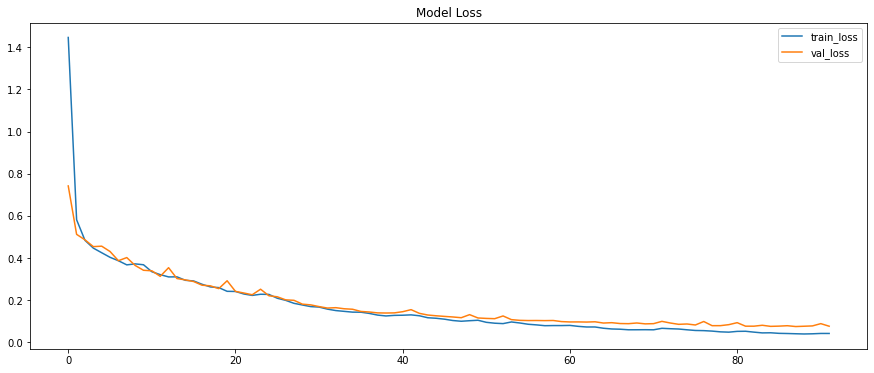

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

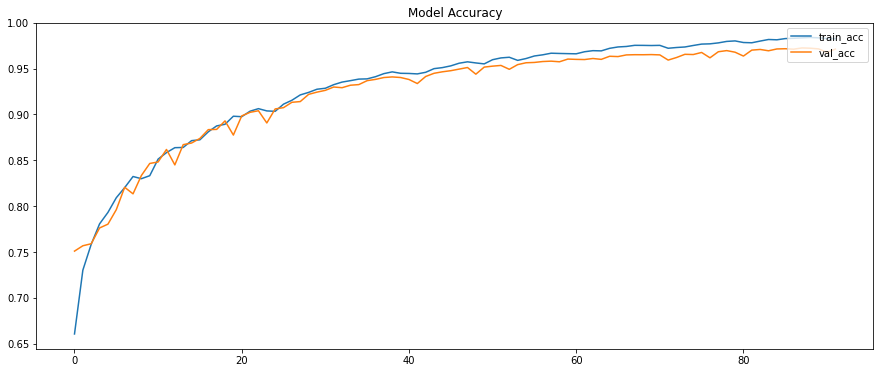

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(H.history['accuracy'], label='train_acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'predicted')

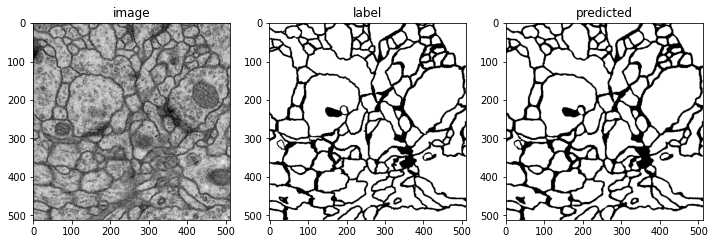

In [ ]:
# predict
img_path = './data/train-volume.tif'
label_path = './data/train-labels.tif'
img = cv2.imread(img_path)
img = cv2.resize(img, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)

label = cv2.imread(label_path)
label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
label = cv2.resize(label, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)

model = load_model('./model_version2_sigmoid_keras.h5')
predict = model.predict(img[np.newaxis,...])
predict[predict<0.5] = 0
predict[predict>=0.5] = 1

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img)
ax[0].set_title('image')
ax[1].imshow(label, cmap='gray')
ax[1].set_title('label')
ax[2].imshow(predict[0][:,:,0], cmap='gray')
ax[2].set_title('predicted')